In [1]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import
import numpy as np
import pandas as pd
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts')
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision')
from utils import *
import sys
import os
import gc


In [ ]:


def subset_data(Y, E, G, start_index, end_index):
    """Subset data based on indices."""
    indices = list(range(start_index, end_index))
    Y_subset = Y[indices]
    E_subset = E[indices]
    G_subset = G[indices]
    return Y_subset, E_subset, G_subset, indices

def load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_enrollment_full.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


In [2]:
# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
    # Path to your total fit model
from clust_huge_amp_fixedPhi import *
total_fit_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/enrollment_model_W0.0001_fulldata_sexspecific.pt'
total_checkpoint = torch.load(total_fit_path, map_location='cpu')
phi_total = total_checkpoint['model_state_dict']['phi'].cpu().numpy()  # shape: (K, D, T)
psi_total = total_checkpoint['model_state_dict']['psi'].cpu().numpy()  # shape: (K, D, T)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_24779/4192832921.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Library/

In [6]:

# Load the RDS file

import pandas as pd

fh_processed=pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/baselinagefamh_withpcs.csv')
len(fh_processed)
disease_names=essentials['disease_names']
prevalence_logit=essentials['prevalence_t']


In [7]:
total_fit_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/enrollment_model_W0.0001_fulldata_sexspecific.pt'
total_checkpoint = torch.load(total_fit_path, map_location='cpu')
phi = total_checkpoint['model_state_dict']['phi'].cpu().numpy()  # shape: (K, D, T)
psi_total = total_checkpoint['model_state_dict']['psi'].cpu().numpy()

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_24779/3965418255.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  total_checkpoint = torch.load(total_fit_path,

In [9]:
total_fit_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/enrollment_model_W0.0001_fulldata_sexspecific.pt'
batch_fit_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt'

total_checkpoint = torch.load(total_fit_path, map_location='cpu')
batch_checkpoint = torch.load(batch_fit_path, map_location='cpu')

print('✅ Loaded both models')

# Extract phi from both
phi_total = total_checkpoint['model_state_dict']['phi'].cpu().numpy()
phi_batch = batch_checkpoint['model_state_dict']['phi'].cpu().numpy()

print(f'\nPhi shapes:')
print(f'  Total fit: {phi_total.shape}')
print(f'  Batch fit: {phi_batch.shape}')

# Check if they're the same
if phi_total.shape == phi_batch.shape:
    # Calculate statistics
    diff = phi_total - phi_batch
    
    print(f'\n=== PHI COMPARISON ===')
    print(f'Correlation: {np.corrcoef(phi_total.flatten(), phi_batch.flatten())[0,1]:.6f}')
    print(f'Mean Absolute Difference: {np.abs(diff).mean():.6f}')
    print(f'Max Absolute Difference: {np.abs(diff).max():.6f}')
    print(f'Relative Error (MAE/Mean): {np.abs(diff).mean() / np.abs(phi_total).mean():.6f}')
    
    # Check per signature
    print(f'\n=== PER-SIGNATURE STATISTICS ===')
    K = phi_total.shape[0]
    for k in range(min(K, 5)):  # Show first 5 signatures
        sig_diff = phi_total[k] - phi_batch[k]
        print(f'Signature {k}:')
        print(f'  Correlation: {np.corrcoef(phi_total[k].flatten(), phi_batch[k].flatten())[0,1]:.6f}')
        print(f'  MAE: {np.abs(sig_diff).mean():.6f}')
        print(f'  Max diff: {np.abs(sig_diff).max():.6f}')
    
    if K > 5:
        print(f'  ... ({K-5} more signatures)')
    
    # Check if they're essentially identical
    if np.allclose(phi_total, phi_batch, rtol=1e-5, atol=1e-8):
        print(f'\n✅ PHI VALUES ARE ESSENTIALLY IDENTICAL (within numerical precision)')
    elif np.allclose(phi_total, phi_batch, rtol=1e-3, atol=1e-6):
        print(f'\n⚠️  PHI VALUES ARE VERY SIMILAR (small differences)')
    else:
        print(f'\n❌ PHI VALUES DIFFER SIGNIFICANTLY')
        
else:
    print(f'\n❌ SHAPE MISMATCH - Cannot compare')
    
# Also check psi if available
print(f'\n=== CHECKING PSI ===')
if 'psi' in total_checkpoint['model_state_dict'] and 'psi' in batch_checkpoint['model_state_dict']:
    psi_total = total_checkpoint['model_state_dict']['psi'].cpu().numpy()
    psi_batch = batch_checkpoint['model_state_dict']['psi'].cpu().numpy()
    
    print(f'Psi shapes:')
    print(f'  Total fit: {psi_total.shape}')
    print(f'  Batch fit: {psi_batch.shape}')
    
    if psi_total.shape == psi_batch.shape:
        psi_diff = psi_total - psi_batch
        print(f'Psi correlation: {np.corrcoef(psi_total.flatten(), psi_batch.flatten())[0,1]:.6f}')
        print(f'Psi MAE: {np.abs(psi_diff).mean():.6f}')
        print(f'Psi Max diff: {np.abs(psi_diff).max():.6f}')
else:
    print('Psi not found in one or both models')

✅ Loaded both models

Phi shapes:
  Total fit: (21, 348, 52)
  Batch fit: (21, 348, 52)

=== PHI COMPARISON ===
Correlation: 1.000000
Mean Absolute Difference: 0.000128
Max Absolute Difference: 0.074416
Relative Error (MAE/Mean): 0.000011

=== PER-SIGNATURE STATISTICS ===
Signature 0:
  Correlation: 1.000000
  MAE: 0.000092
  Max diff: 0.005242
Signature 1:
  Correlation: 1.000000
  MAE: 0.000139
  Max diff: 0.010036
Signature 2:
  Correlation: 1.000000
  MAE: 0.000203
  Max diff: 0.047878
Signature 3:
  Correlation: 1.000000
  MAE: 0.000255
  Max diff: 0.014029
Signature 4:
  Correlation: 1.000000
  MAE: 0.000024
  Max diff: 0.002824
  ... (16 more signatures)

❌ PHI VALUES DIFFER SIGNIFICANTLY

=== CHECKING PSI ===
Psi shapes:
  Total fit: (21, 348)
  Batch fit: (21, 348)
Psi correlation: 0.999962
Psi MAE: 0.001313
Psi Max diff: 0.497025


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_24779/1662230533.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  total_checkpoint = torch.load(total_fit_path,

✅ Saved temporal evolution plot to: pyScripts/new_oct_revision/phi_temporal_evolution.png

PHI TEMPORAL EVOLUTION ANALYSIS

MI-Inflammatory (Disease 112, Signature 5):
  Correlation: 0.99999982
  MAE: 0.001454, Max diff: 0.003535
  Age slope (Total): 0.143138 per year
  Age slope (Batch): 0.143097 per year
  Value at age 30: Total=-12.451, Batch=-12.452
  Value at age 80: Total=-5.881, Batch=-5.878

MI-Cardiovascular (Disease 112, Signature 3):
  Correlation: 0.99999998
  MAE: 0.000480, Max diff: 0.001328
  Age slope (Total): 0.129653 per year
  Age slope (Batch): 0.129659 per year
  Value at age 30: Total=-15.429, Batch=-15.429
  Value at age 80: Total=-8.575, Batch=-8.575

MI-Metabolic (Disease 112, Signature 12):
  Correlation: 1.00000000
  MAE: 0.000027, Max diff: 0.000054
  Age slope (Total): 0.131238 per year
  Age slope (Batch): 0.131238 per year
  Value at age 30: Total=-15.474, Batch=-15.474
  Value at age 80: Total=-8.566, Batch=-8.566

Disease47-Sig15 (Disease 47, Signature 

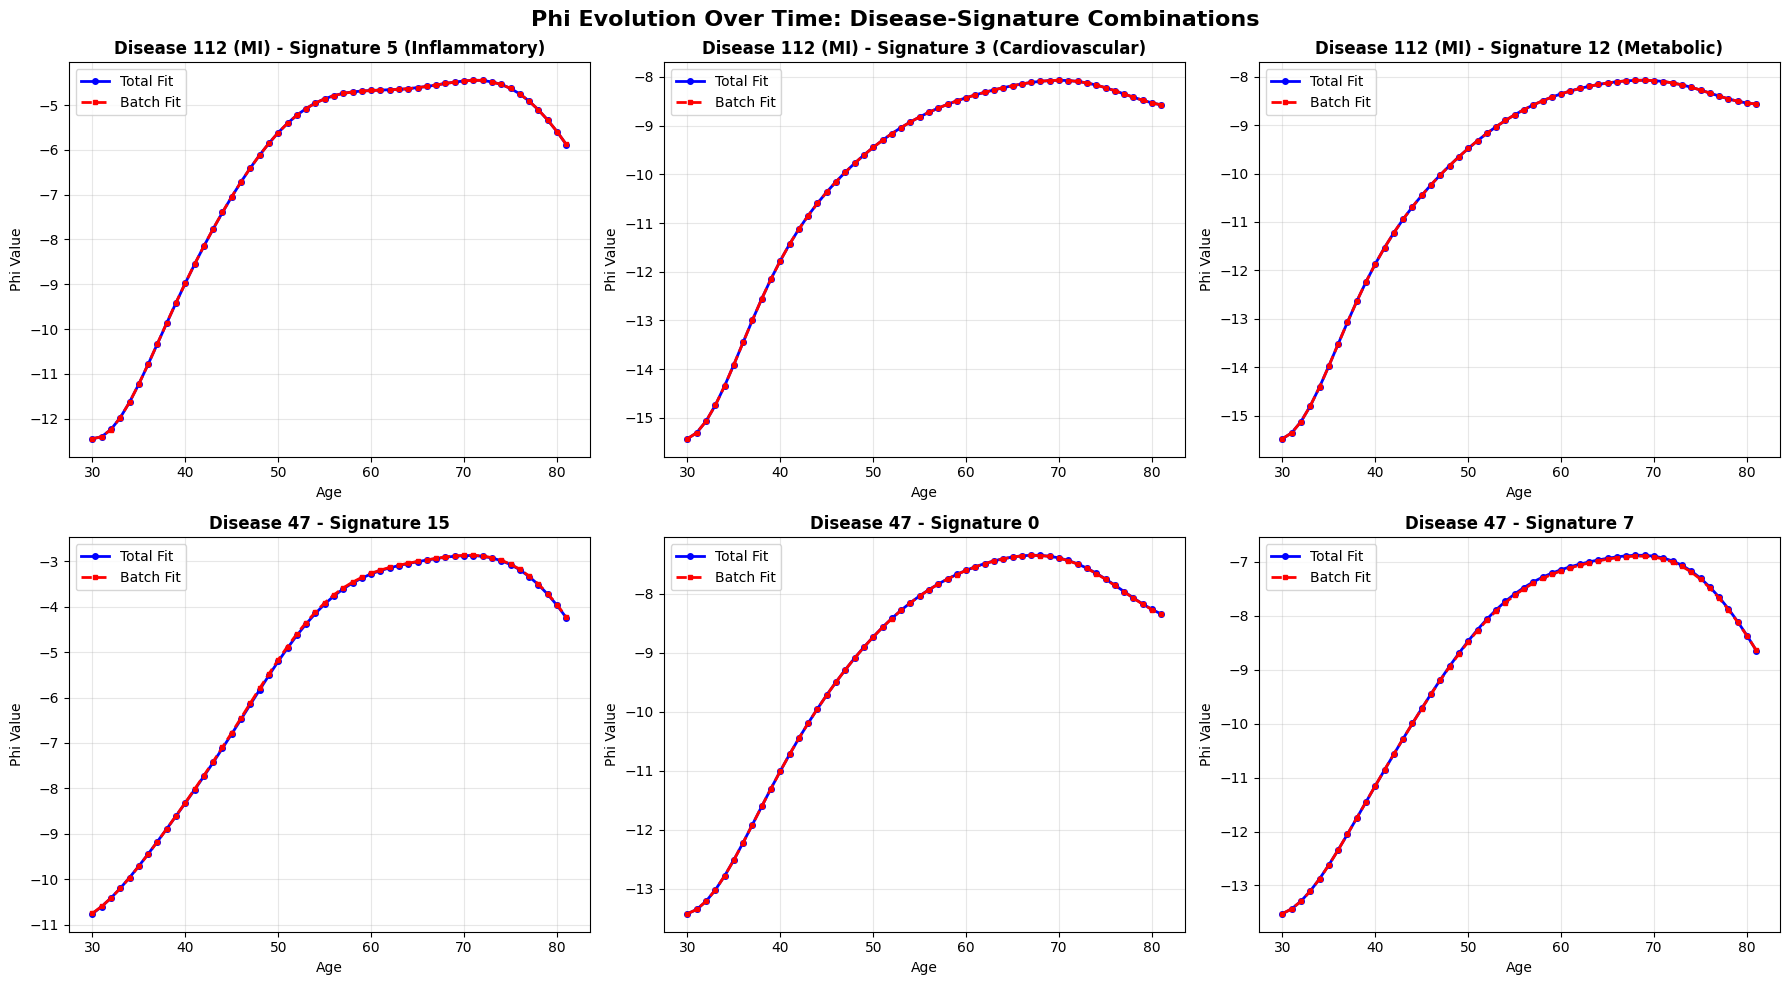

In [14]:
phi_total = total_checkpoint['model_state_dict']['phi'].cpu().numpy()
phi_batch = batch_checkpoint['model_state_dict']['phi'].cpu().numpy()

# Create time axis (ages 30-81)
ages = np.arange(30, 82)

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Phi Evolution Over Time: Disease-Signature Combinations', fontsize=16, fontweight='bold')

# Plot 1: Disease 112 (Myocardial Infarction) - Signature 5 (Inflammatory/Rheumatologic)
ax1 = axes[0, 0]
disease_idx = 112
sig_idx = 5
ax1.plot(ages, phi_total[sig_idx, disease_idx, :], 'b-', linewidth=2, label='Total Fit', marker='o', markersize=4)
ax1.plot(ages, phi_batch[sig_idx, disease_idx, :], 'r--', linewidth=2, label='Batch Fit', marker='s', markersize=3)
ax1.set_title(f'Disease {disease_idx} (MI) - Signature {sig_idx} (Inflammatory)', fontweight='bold')
ax1.set_xlabel('Age')
ax1.set_ylabel('Phi Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Disease 112 (Myocardial Infarction) - Signature 3 (Cardiovascular)
ax2 = axes[0, 1]
sig_idx = 3
ax2.plot(ages, phi_total[sig_idx, disease_idx, :], 'b-', linewidth=2, label='Total Fit', marker='o', markersize=4)
ax2.plot(ages, phi_batch[sig_idx, disease_idx, :], 'r--', linewidth=2, label='Batch Fit', marker='s', markersize=3)
ax2.set_title(f'Disease {disease_idx} (MI) - Signature {sig_idx} (Cardiovascular)', fontweight='bold')
ax2.set_xlabel('Age')
ax2.set_ylabel('Phi Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Disease 112 (Myocardial Infarction) - Signature 12 (Metabolic)
ax3 = axes[0, 2]
sig_idx = 12
ax3.plot(ages, phi_total[sig_idx, disease_idx, :], 'b-', linewidth=2, label='Total Fit', marker='o', markersize=4)
ax3.plot(ages, phi_batch[sig_idx, disease_idx, :], 'r--', linewidth=2, label='Batch Fit', marker='s', markersize=3)
ax3.set_title(f'Disease {disease_idx} (MI) - Signature {sig_idx} (Metabolic)', fontweight='bold')
ax3.set_xlabel('Age')
ax3.set_ylabel('Phi Value')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Disease 47 - Signature 15
ax4 = axes[1, 0]
disease_idx = 47
sig_idx = 15
ax4.plot(ages, phi_total[sig_idx, disease_idx, :], 'b-', linewidth=2, label='Total Fit', marker='o', markersize=4)
ax4.plot(ages, phi_batch[sig_idx, disease_idx, :], 'r--', linewidth=2, label='Batch Fit', marker='s', markersize=3)
ax4.set_title(f'Disease {disease_idx} - Signature {sig_idx}', fontweight='bold')
ax4.set_xlabel('Age')
ax4.set_ylabel('Phi Value')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Disease 47 - Signature 0
ax5 = axes[1, 1]
sig_idx = 0
ax5.plot(ages, phi_total[sig_idx, disease_idx, :], 'b-', linewidth=2, label='Total Fit', marker='o', markersize=4)
ax5.plot(ages, phi_batch[sig_idx, disease_idx, :], 'r--', linewidth=2, label='Batch Fit', marker='s', markersize=3)
ax5.set_title(f'Disease {disease_idx} - Signature {sig_idx}', fontweight='bold')
ax5.set_xlabel('Age')
ax5.set_ylabel('Phi Value')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Disease 47 - Signature 7
ax6 = axes[1, 2]
sig_idx = 7
ax6.plot(ages, phi_total[sig_idx, disease_idx, :], 'b-', linewidth=2, label='Total Fit', marker='o', markersize=4)
ax6.plot(ages, phi_batch[sig_idx, disease_idx, :], 'r--', linewidth=2, label='Batch Fit', marker='s', markersize=3)
ax6.set_title(f'Disease {disease_idx} - Signature {sig_idx}', fontweight='bold')
ax6.set_xlabel('Age')
ax6.set_ylabel('Phi Value')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/phi_temporal_evolution.png', dpi=150, bbox_inches='tight')
print('✅ Saved temporal evolution plot to: pyScripts/new_oct_revision/phi_temporal_evolution.png')

# Also print some statistics about the curves
print('\n' + '='*80)
print('PHI TEMPORAL EVOLUTION ANALYSIS')
print('='*80)

disease_sig_pairs = [
    (112, 5, 'MI-Inflammatory'),
    (112, 3, 'MI-Cardiovascular'),
    (112, 12, 'MI-Metabolic'),
    (47, 15, 'Disease47-Sig15'),
    (47, 0, 'Disease47-Sig0'),
    (47, 7, 'Disease47-Sig7')
]

for disease_idx, sig_idx, label in disease_sig_pairs:
    phi_traj_total = phi_total[sig_idx, disease_idx, :]
    phi_traj_batch = phi_batch[sig_idx, disease_idx, :]
    
    # Calculate statistics
    diff = phi_traj_total - phi_traj_batch
    corr = np.corrcoef(phi_traj_total, phi_traj_batch)[0,1]
    mae = np.abs(diff).mean()
    max_diff = np.abs(diff).max()
    
    # Age trends
    slope_total = np.polyfit(ages, phi_traj_total, 1)[0]
    slope_batch = np.polyfit(ages, phi_traj_batch, 1)[0]
    
    print(f'\n{label} (Disease {disease_idx}, Signature {sig_idx}):')
    print(f'  Correlation: {corr:.8f}')
    print(f'  MAE: {mae:.6f}, Max diff: {max_diff:.6f}')
    print(f'  Age slope (Total): {slope_total:.6f} per year')
    print(f'  Age slope (Batch): {slope_batch:.6f} per year')
    print(f'  Value at age 30: Total={phi_traj_total[0]:.3f}, Batch={phi_traj_batch[0]:.3f}')
    print(f'  Value at age 80: Total={phi_traj_total[-1]:.3f}, Batch={phi_traj_batch[-1]:.3f}')

In [5]:
print('Loading models...')
batch_model_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_10000_20000.pt'
refit_model_path = '/Users/sarahurbut/Library/CloudStorage/DB_backup_5132025941p/resultshighamp/results/output_10000_20000/model.pt'

try:
    batch_checkpoint = torch.load(batch_model_path, map_location='cpu')
    refit_checkpoint = torch.load(refit_model_path, map_location='cpu')
    print('✅ Loaded both models')
except Exception as e:
    print(f'❌ Error loading models: {e}')
    exit()


Loading models...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_25259/3529800675.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_checkpoint = torch.load(batch_model_pat

✅ Loaded both models


Batch phi shape: (21, 348, 52)
Refit phi shape: (21, 348, 52)
✅ Saved comparison plot to: pyScripts/new_oct_revision/phi_batch_vs_refit_comparison.png

PHI TRAJECTORY COMPARISON: BATCH vs REFIT (with PCs)

MI-Inflammatory (Disease 112, Signature 5):
  Correlation: 0.999997
  MAE: 0.012878, Max diff: 0.032439
  Age slope - Batch: 0.149273, Refit: 0.148457
  Age 30 - Batch: -12.518, Refit: -12.512
  Age 80 - Batch: -5.436, Refit: -5.468

MI-Cardiovascular (Disease 112, Signature 3):
  Correlation: 0.999996
  MAE: 0.005102, Max diff: 0.022477
  Age slope - Batch: 0.129670, Refit: 0.129677
  Age 30 - Batch: -15.420, Refit: -15.427
  Age 80 - Batch: -8.560, Refit: -8.582

MI-Metabolic (Disease 112, Signature 12):
  Correlation: 1.000000
  MAE: 0.001325, Max diff: 0.007133
  Age slope - Batch: 0.131241, Refit: 0.131223
  Age 30 - Batch: -15.473, Refit: -15.473
  Age 80 - Batch: -8.567, Refit: -8.575

Disease47-Sig15 (Disease 47, Signature 15):
  Correlation: 0.999227
  MAE: 0.057271, Max dif

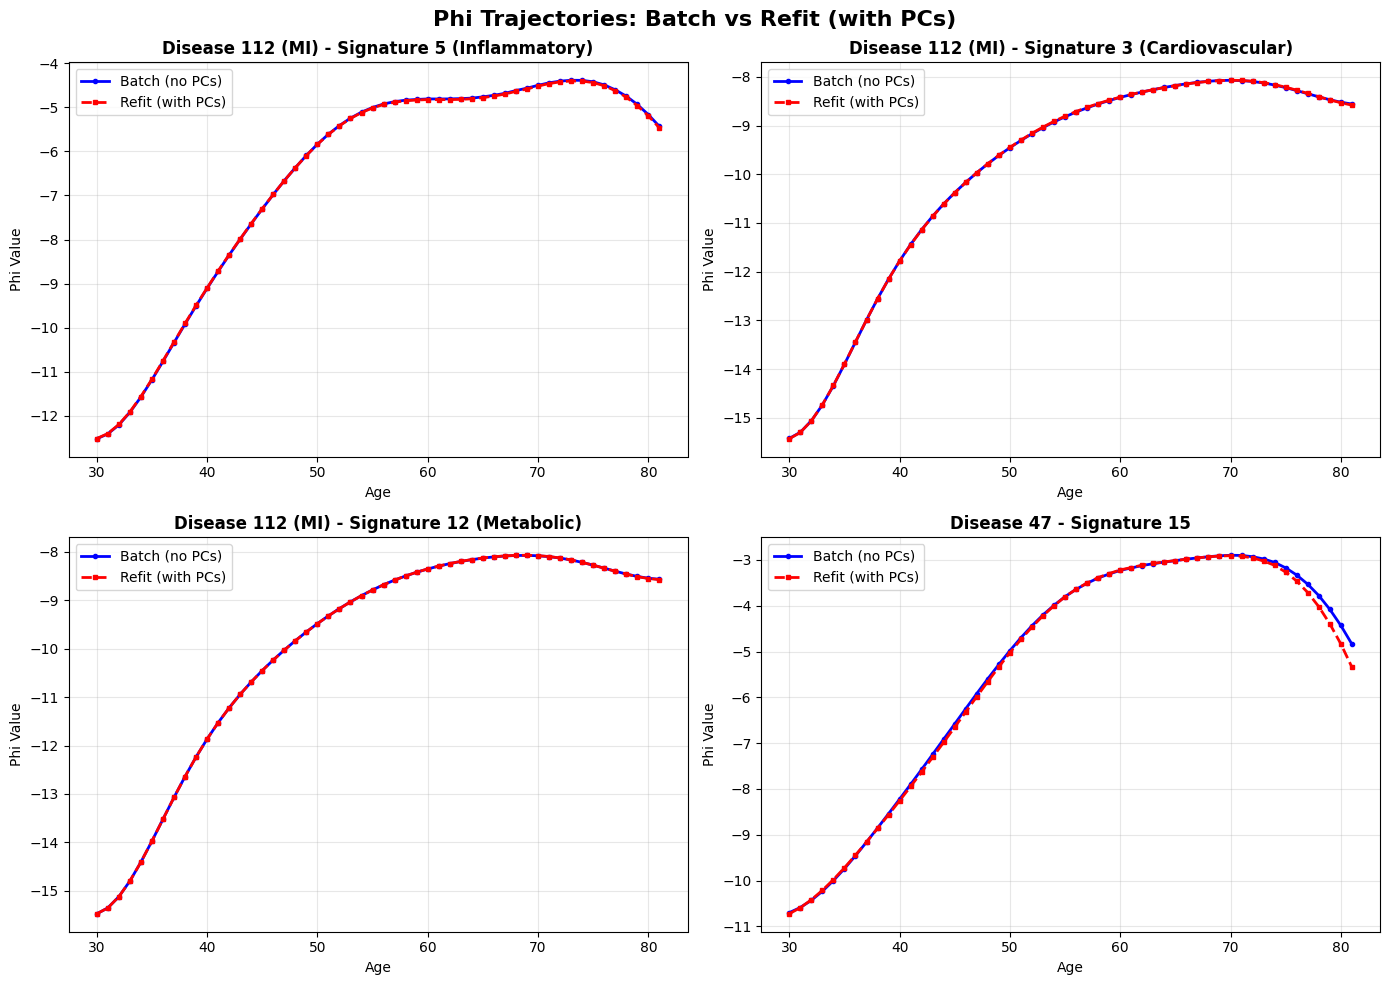

In [6]:

# Extract phi from both
phi_batch = batch_checkpoint['model_state_dict']['phi'].cpu().numpy()
phi_refit = refit_checkpoint['model_state_dict']['phi'].cpu().numpy()

print(f'Batch phi shape: {phi_batch.shape}')
print(f'Refit phi shape: {phi_refit.shape}')

# Create time axis (ages 30-81)
ages = np.arange(30, 82)

# Create comparison plots for specific disease-signature combinations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Phi Trajectories: Batch vs Refit (with PCs)', fontsize=16, fontweight='bold')

# Disease 112 (MI) combinations
disease_idx = 112

# Plot 1: MI - Signature 5 (Inflammatory)
ax1 = axes[0, 0]
sig_idx = 5
ax1.plot(ages, phi_batch[sig_idx, disease_idx, :], 'b-', linewidth=2, label='Batch (no PCs)', marker='o', markersize=3)
ax1.plot(ages, phi_refit[sig_idx, disease_idx, :], 'r--', linewidth=2, label='Refit (with PCs)', marker='s', markersize=3)
ax1.set_title(f'Disease {disease_idx} (MI) - Signature {sig_idx} (Inflammatory)', fontweight='bold')
ax1.set_xlabel('Age')
ax1.set_ylabel('Phi Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: MI - Signature 3 (Cardiovascular)
ax2 = axes[0, 1]
sig_idx = 3
ax2.plot(ages, phi_batch[sig_idx, disease_idx, :], 'b-', linewidth=2, label='Batch (no PCs)', marker='o', markersize=3)
ax2.plot(ages, phi_refit[sig_idx, disease_idx, :], 'r--', linewidth=2, label='Refit (with PCs)', marker='s', markersize=3)
ax2.set_title(f'Disease {disease_idx} (MI) - Signature {sig_idx} (Cardiovascular)', fontweight='bold')
ax2.set_xlabel('Age')
ax2.set_ylabel('Phi Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: MI - Signature 12 (Metabolic)
ax3 = axes[1, 0]
sig_idx = 12
ax3.plot(ages, phi_batch[sig_idx, disease_idx, :], 'b-', linewidth=2, label='Batch (no PCs)', marker='o', markersize=3)
ax3.plot(ages, phi_refit[sig_idx, disease_idx, :], 'r--', linewidth=2, label='Refit (with PCs)', marker='s', markersize=3)
ax3.set_title(f'Disease {disease_idx} (MI) - Signature {sig_idx} (Metabolic)', fontweight='bold')
ax3.set_xlabel('Age')
ax3.set_ylabel('Phi Value')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Disease 47 - Signature 15
ax4 = axes[1, 1]
disease_idx = 47
sig_idx = 15
ax4.plot(ages, phi_batch[sig_idx, disease_idx, :], 'b-', linewidth=2, label='Batch (no PCs)', marker='o', markersize=3)
ax4.plot(ages, phi_refit[sig_idx, disease_idx, :], 'r--', linewidth=2, label='Refit (with PCs)', marker='s', markersize=3)
ax4.set_title(f'Disease {disease_idx} - Signature {sig_idx}', fontweight='bold')
ax4.set_xlabel('Age')
ax4.set_ylabel('Phi Value')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/phi_batch_vs_refit_comparison.png', dpi=150, bbox_inches='tight')
print('✅ Saved comparison plot to: pyScripts/new_oct_revision/phi_batch_vs_refit_comparison.png')

# Print comparison statistics
print('\n' + '='*80)
print('PHI TRAJECTORY COMPARISON: BATCH vs REFIT (with PCs)')
print('='*80)

disease_sig_pairs = [
    (112, 5, 'MI-Inflammatory'),
    (112, 3, 'MI-Cardiovascular'),
    (112, 12, 'MI-Metabolic'),
    (47, 15, 'Disease47-Sig15')
]

for disease_idx, sig_idx, label in disease_sig_pairs:
    phi_batch_traj = phi_batch[sig_idx, disease_idx, :]
    phi_refit_traj = phi_refit[sig_idx, disease_idx, :]
    
    # Calculate statistics
    corr = np.corrcoef(phi_batch_traj, phi_refit_traj)[0,1]
    diff = phi_batch_traj - phi_refit_traj
    mae = np.abs(diff).mean()
    max_diff = np.abs(diff).max()
    
    # Age trends
    slope_batch = np.polyfit(ages, phi_batch_traj, 1)[0]
    slope_refit = np.polyfit(ages, phi_refit_traj, 1)[0]
    
    print(f'\n{label} (Disease {disease_idx}, Signature {sig_idx}):')
    print(f'  Correlation: {corr:.6f}')
    print(f'  MAE: {mae:.6f}, Max diff: {max_diff:.6f}')
    print(f'  Age slope - Batch: {slope_batch:.6f}, Refit: {slope_refit:.6f}')
    print(f'  Age 30 - Batch: {phi_batch_traj[0]:.3f}, Refit: {phi_refit_traj[0]:.3f}')
    print(f'  Age 80 - Batch: {phi_batch_traj[-1]:.3f}, Refit: {phi_refit_traj[-1]:.3f}')

POOLING BATCH RESULTS
Pooling no-PC results from /Users/sarahurbut/Library/CloudStorage/DB_backup_5132025941p/resultshighamp/results...
  ✅ Loaded batch 0 (0-10000)
  ✅ Loaded batch 1 (10000-20000)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_25259/525109578.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(batch_path, map_locat

  ✅ Loaded batch 2 (20000-30000)
  ✅ Loaded batch 3 (30000-40000)
  ✅ Loaded batch 4 (40000-50000)
  ✅ Loaded batch 5 (50000-60000)
  ✅ Loaded batch 6 (60000-70000)
  ✅ Loaded batch 7 (70000-80000)
  ✅ Loaded batch 8 (80000-90000)
  ✅ Loaded batch 9 (90000-100000)
  ✅ Loaded batch 10 (100000-110000)
  ✅ Loaded batch 11 (110000-120000)
  ✅ Loaded batch 12 (120000-130000)
  ✅ Loaded batch 13 (130000-140000)
  ✅ Loaded batch 14 (140000-150000)
  ✅ Loaded batch 15 (150000-160000)
  ✅ Loaded batch 16 (160000-170000)
  ✅ Loaded batch 17 (170000-180000)
  ✅ Loaded batch 18 (180000-190000)
  ✅ Loaded batch 19 (190000-200000)
  ✅ Loaded batch 20 (200000-210000)
  ✅ Loaded batch 21 (210000-220000)
  ✅ Loaded batch 22 (220000-230000)
  ✅ Loaded batch 23 (230000-240000)
  ✅ Loaded batch 24 (240000-250000)
  ✅ Loaded batch 25 (250000-260000)
  ✅ Loaded batch 26 (260000-270000)
  ✅ Loaded batch 27 (270000-280000)
  ✅ Loaded batch 28 (280000-290000)
  ✅ Loaded batch 29 (290000-300000)
  ✅ Loaded batc

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_25259/525109578.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(batch_path, map_locat

  ✅ Loaded batch 1 (10000-20000)
  ✅ Loaded batch 2 (20000-30000)
  ✅ Loaded batch 3 (30000-40000)
  ✅ Loaded batch 4 (40000-50000)
  ✅ Loaded batch 5 (50000-60000)
  ✅ Loaded batch 6 (60000-70000)
  ✅ Loaded batch 7 (70000-80000)
  ✅ Loaded batch 8 (80000-90000)
  ✅ Loaded batch 9 (90000-100000)
  ✅ Loaded batch 10 (100000-110000)
  ✅ Loaded batch 11 (110000-120000)
  ✅ Loaded batch 12 (120000-130000)
  ✅ Loaded batch 13 (130000-140000)
  ✅ Loaded batch 14 (140000-150000)
  ✅ Loaded batch 15 (150000-160000)
  ✅ Loaded batch 16 (160000-170000)
  ✅ Loaded batch 17 (170000-180000)
  ✅ Loaded batch 18 (180000-190000)
  ✅ Loaded batch 19 (190000-200000)
  ✅ Loaded batch 20 (200000-210000)
  ✅ Loaded batch 21 (210000-220000)
  ✅ Loaded batch 22 (220000-230000)
  ✅ Loaded batch 23 (230000-240000)
  ✅ Loaded batch 24 (240000-250000)
  ✅ Loaded batch 25 (250000-260000)
  ✅ Loaded batch 26 (260000-270000)
  ✅ Loaded batch 27 (270000-280000)
  ✅ Loaded batch 28 (280000-290000)
  ✅ Loaded batch 2

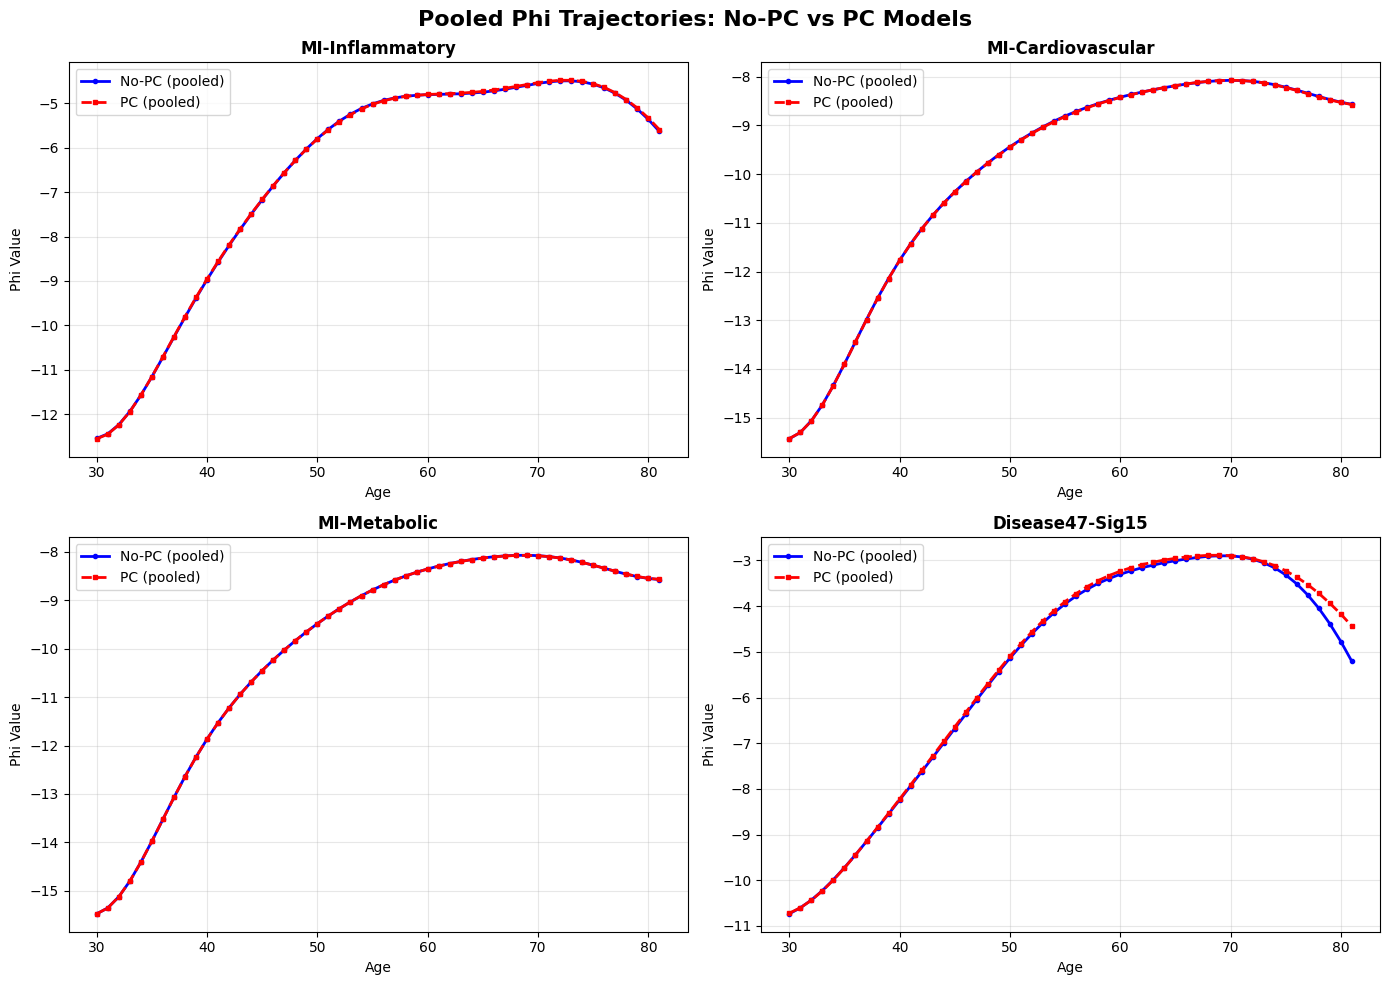

In [ ]:
import torch
import numpy as np
import glob
import os

import torch
import numpy as np
import glob
import os

def pool_batch_results_no_pc(base_path, n_batches=41):
    '''
    Pool phi results from resultshighamp batches (output_*_*/model.pt)
    '''
    print(f'Pooling no-PC results from {base_path}...')
    
    phi_list = []
    valid_batches = 0
    
    for i in range(n_batches):
        start_idx = i * 10000
        end_idx = (i + 1) * 10000
        
        # resultshighamp format: output_0_10000/model.pt
        batch_path = os.path.join(base_path, f'output_{start_idx}_{end_idx}', 'model.pt')
        
        if os.path.exists(batch_path):
            try:
                checkpoint = torch.load(batch_path, map_location='cpu')
                if 'model_state_dict' in checkpoint and 'phi' in checkpoint['model_state_dict']:
                    phi_batch = checkpoint['model_state_dict']['phi'].cpu().numpy()
                    phi_list.append(phi_batch)
                    valid_batches += 1
                    print(f'  ✅ Loaded batch {i} ({start_idx}-{end_idx})')
                else:
                    print(f'  ❌ No phi in batch {i} ({start_idx}-{end_idx})')
            except Exception as e:
                print(f'  ❌ Error loading batch {i}: {e}')
        else:
            print(f'  ❌ File not found: {batch_path}')
    
    if phi_list:
        pooled_phi = np.mean(phi_list, axis=0)
        print(f'✅ Pooled {valid_batches} no-PC batches. Final shape: {pooled_phi.shape}')
        return pooled_phi
    else:
        print(f'❌ No valid no-PC batches found')
        return None

def pool_batch_results_pc(base_path, n_batches=41):
    '''
    Pool phi results from retrospective batches (enrollment_model_W0.0001_batch_*_*.pt)
    '''
    print(f'Pooling PC results from {base_path}...')
    
    phi_list = []
    valid_batches = 0
    
    for i in range(n_batches):
        start_idx = i * 10000
        end_idx = (i + 1) * 10000
        
        # retrospective format: enrollment_model_W0.0001_batch_0_10000.pt
        batch_path = os.path.join(base_path, f'enrollment_model_W0.0001_batch_{start_idx}_{end_idx}.pt')
        
        if os.path.exists(batch_path):
            try:
                checkpoint = torch.load(batch_path, map_location='cpu')
                if 'model_state_dict' in checkpoint and 'phi' in checkpoint['model_state_dict']:
                    phi_batch = checkpoint['model_state_dict']['phi'].cpu().numpy()
                    phi_list.append(phi_batch)
                    valid_batches += 1
                    print(f'  ✅ Loaded batch {i} ({start_idx}-{end_idx})')
                else:
                    print(f'  ❌ No phi in batch {i} ({start_idx}-{end_idx})')
            except Exception as e:
                print(f'  ❌ Error loading batch {i}: {e}')
        else:
            print(f'  ❌ File not found: {batch_path}')
    
    if phi_list:
        pooled_phi = np.mean(phi_list, axis=0)
        print(f'✅ Pooled {valid_batches} PC batches. Final shape: {pooled_phi.shape}')
        return pooled_phi
    else:
        print(f'❌ No valid PC batches found')
        return None

# Pool results from both approaches
print('='*80)
print('POOLING BATCH RESULTS')
print('='*80)

# Pool no-PC model (resultshighamp)
no_pc_base = '/Users/sarahurbut/Library/CloudStorage/DB_backup_5132025941p/resultshighamp/results'
phi_no_pc = pool_batch_results_no_pc(no_pc_base, n_batches=41)

print()

# Pool PC model (retrospective)
pc_base = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full'
phi_pc = pool_batch_results_pc(pc_base, n_batches=41)

# Compare the pooled results
if phi_no_pc is not None and phi_pc is not None:
    print('\n' + '='*80)
    print('COMPARING POOLED PHI RESULTS')
    print('='*80)
    
    # Overall comparison
    diff = phi_no_pc - phi_pc
    corr = np.corrcoef(phi_no_pc.flatten(), phi_pc.flatten())[0,1]
    
    print(f'Overall correlation: {corr:.8f}')
    print(f'Mean absolute difference: {np.abs(diff).mean():.6f}')
    print(f'Max absolute difference: {np.abs(diff).max():.6f}')
    print(f'Relative error: {np.abs(diff).mean() / np.abs(phi_no_pc).mean():.6f}')
    
    # Specific disease-signature combinations
    print(f'\n=== SPECIFIC COMBINATIONS ===')
    
    disease_sig_pairs = [
        (112, 5, 'MI-Inflammatory'),
        (112, 3, 'MI-Cardiovascular'), 
        (112, 12, 'MI-Metabolic'),
        (47, 15, 'Disease47-Sig15'),
        (47, 15, 'Disease47-Sig15'),
        (19, 7, 'Disease47-Sig15'),
        (47, , 'Disease47-Sig15'),
        (47, 15, 'Disease47-Sig15'),
        (47, 15, 'Disease47-Sig15'),
        (47, 15, 'Disease47-Sig15'),
        (47, 15, 'Disease47-Sig15'),
        (47, 15, 'Disease47-Sig15'),
        (47, 15, 'Disease47-Sig15'),
        (47, 15, 'Disease47-Sig15'),
    ]
    
    ages = np.arange(30, 82)
    
    for disease_idx, sig_idx, label in disease_sig_pairs:
        phi_no_pc_traj = phi_no_pc[sig_idx, disease_idx, :]
        phi_pc_traj = phi_pc[sig_idx, disease_idx, :]
        
        corr_traj = np.corrcoef(phi_no_pc_traj, phi_pc_traj)[0,1]
        diff_traj = phi_no_pc_traj - phi_pc_traj
        mae_traj = np.abs(diff_traj).mean()
        max_diff_traj = np.abs(diff_traj).max()
        
        print(f'\n{label} (Disease {disease_idx}, Signature {sig_idx}):')
        print(f'  Correlation: {corr_traj:.6f}')
        print(f'  MAE: {mae_traj:.6f}, Max diff: {max_diff_traj:.6f}')
        print(f'  Age 30: No-PC={phi_no_pc_traj[0]:.3f}, PC={phi_pc_traj[0]:.3f}')
        print(f'  Age 80: No-PC={phi_no_pc_traj[-1]:.3f}, PC={phi_pc_traj[-1]:.3f}')
    
    # Save the comparison plot
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Pooled Phi Trajectories: No-PC vs PC Models', fontsize=16, fontweight='bold')
    
    for i, (disease_idx, sig_idx, label) in enumerate(disease_sig_pairs):
        ax = axes[i//2, i%2]
        
        phi_no_pc_traj = phi_no_pc[sig_idx, disease_idx, :]
        phi_pc_traj = phi_pc[sig_idx, disease_idx, :]
        
        ax.plot(ages, phi_no_pc_traj, 'b-', linewidth=2, label='No-PC (pooled)', marker='o', markersize=3)
        ax.plot(ages, phi_pc_traj, 'r--', linewidth=2, label='PC (pooled)', marker='s', markersize=3)
        
        ax.set_title(f'{label}', fontweight='bold')
        ax.set_xlabel('Age')
        ax.set_ylabel('Phi Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/phi_pooled_comparison.png', dpi=150, bbox_inches='tight')
    print('\n✅ Saved pooled comparison plot to: pyScripts/new_oct_revision/phi_pooled_comparison.png')
    
else:
    print('\n❌ Could not compare - one or both pooled results failed')

✅ Saved comprehensive trajectories plot to: pyScripts/new_oct_revisionapr/phi_trajectories_comprehensive.png
✅ Saved statistics plot to: pyScripts/new_oct_revision/phi_comparison_statistics.png
\n================================================================================
SUMMARY STATISTICS
Mean correlation: 0.999923
Min correlation: 0.999227
Mean MAE: 0.008349
Max MAE: 0.057271
Mean age bias: 0.020653 (positive = worse at older ages)


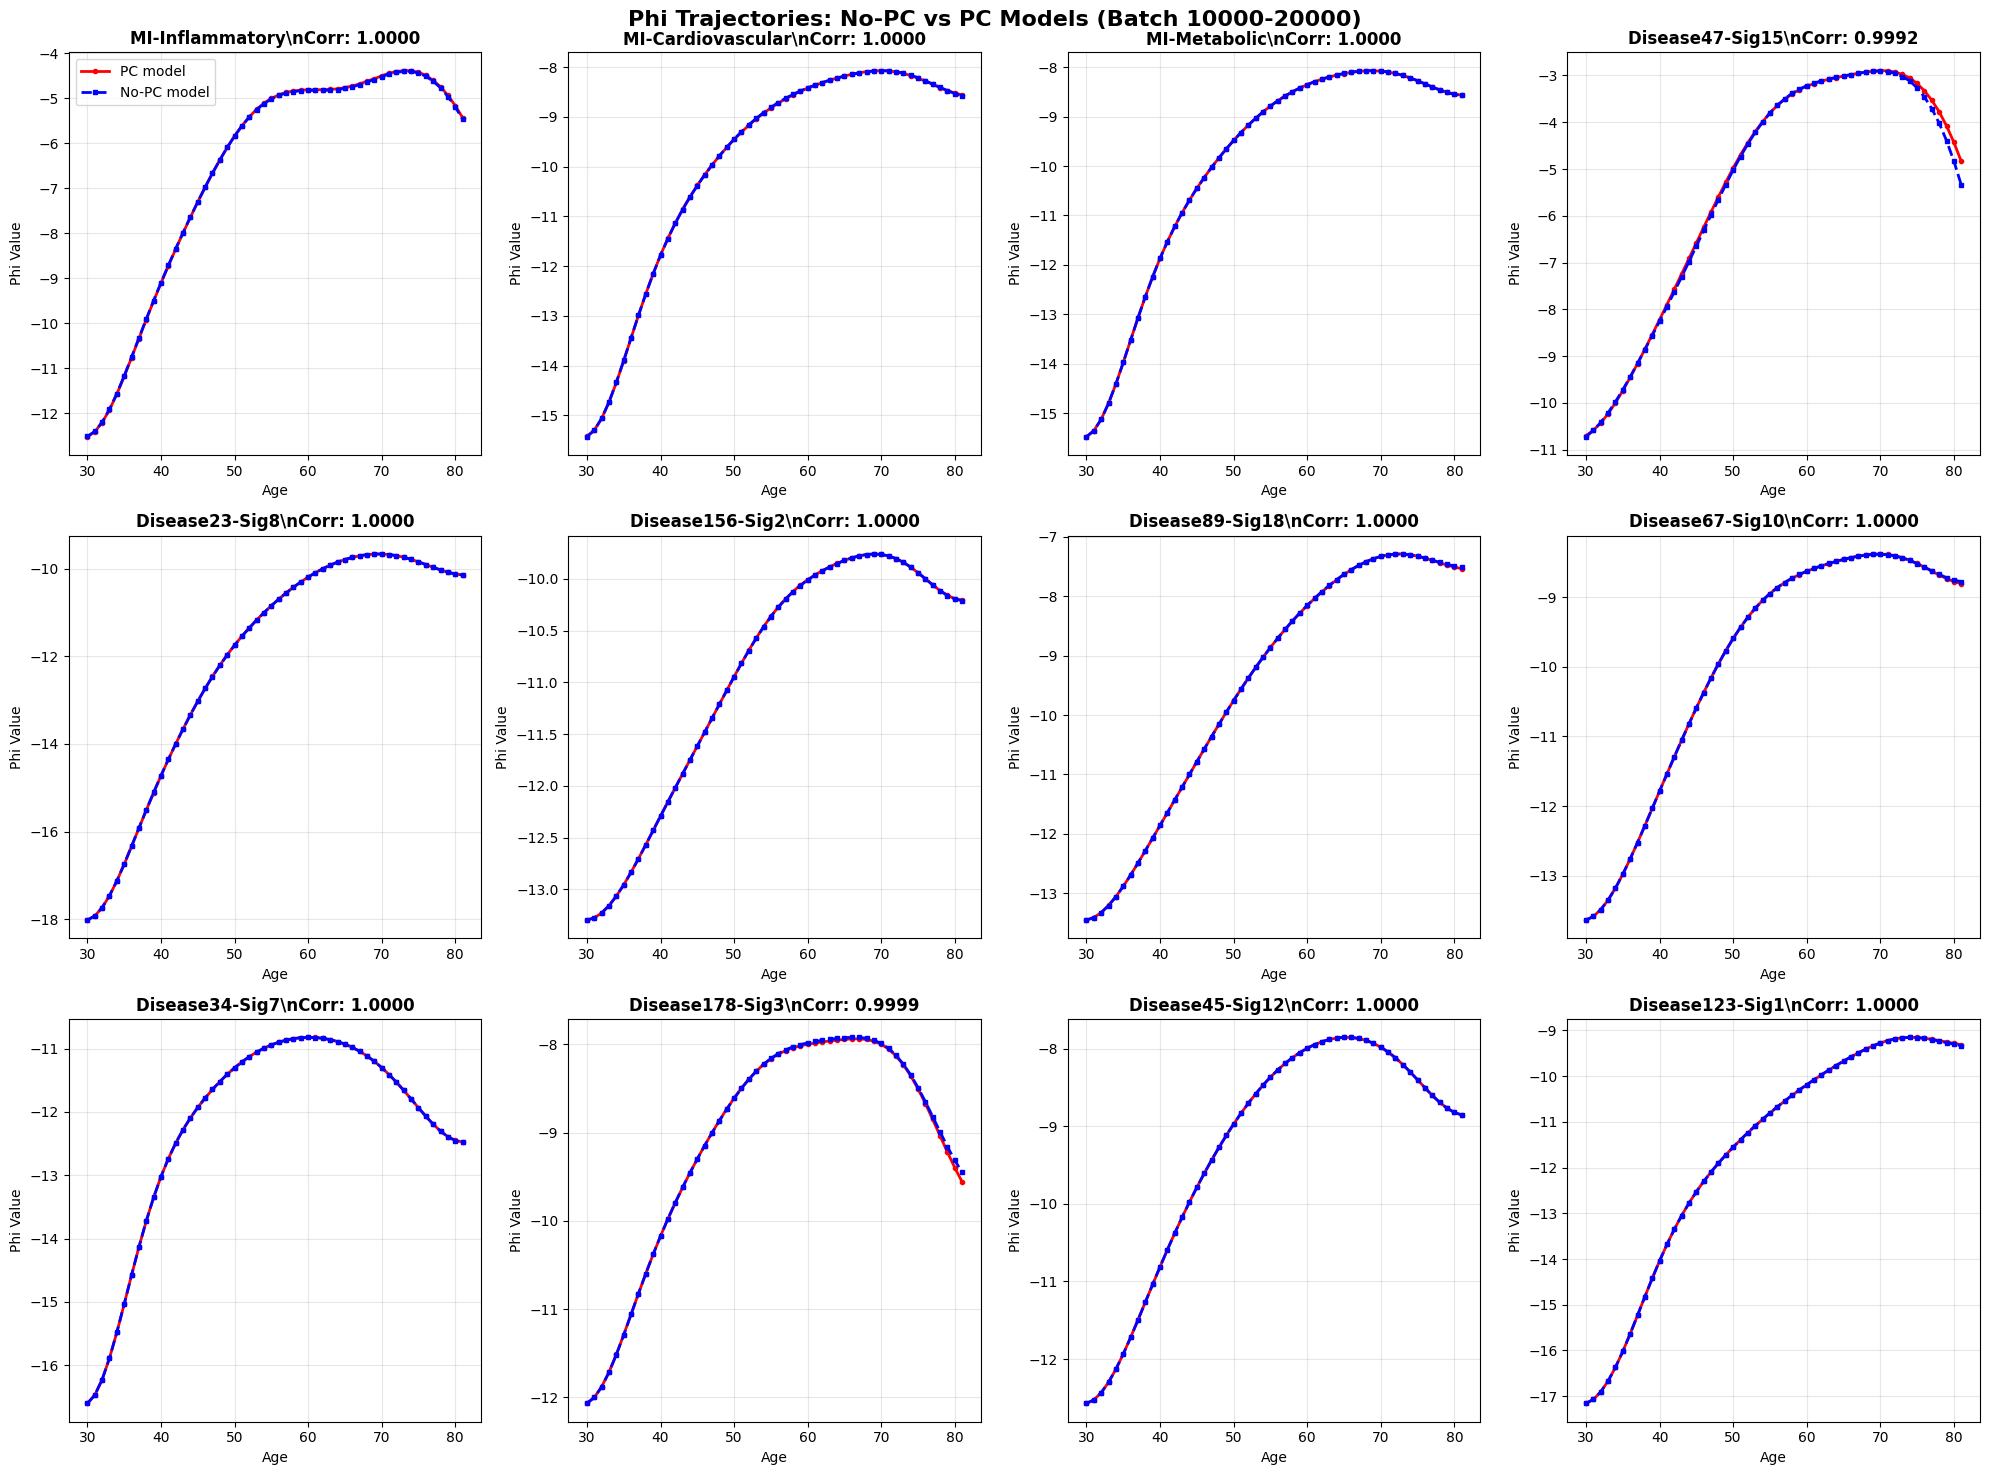

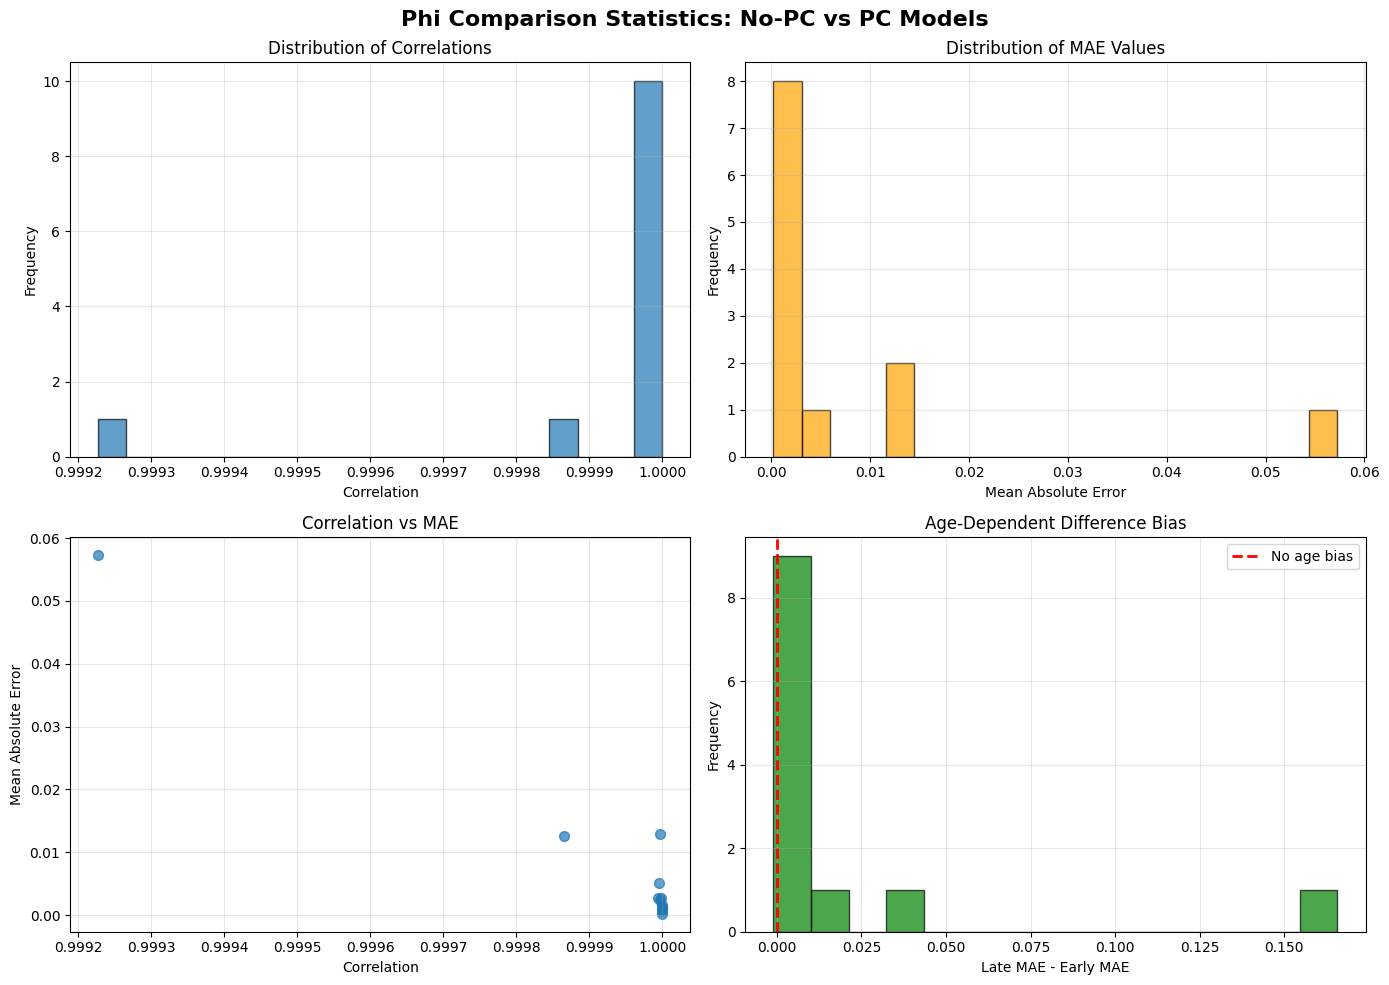

In [31]:
phi_new = new_batch1['model_state_dict']['phi'].cpu().numpy()
phi_old = old_batch1['model_state_dict']['phi'].cpu().numpy()

ages = np.arange(30, 82)

# Create multiple plots with different disease-signature combinations
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Phi Trajectories: No-PC vs PC Models (Batch 10000-20000)', fontsize=16, fontweight='bold')

# Define disease-signature pairs to test
disease_sig_pairs = [
    (112, 5, 'MI-Inflammatory'),
    (112, 3, 'MI-Cardiovascular'), 
    (112, 12, 'MI-Metabolic'),
    (47, 15, 'Disease47-Sig15'),
    (23, 8, 'Disease23-Sig8'),
    (156, 2, 'Disease156-Sig2'),
    (89, 18, 'Disease89-Sig18'),
    (67, 10, 'Disease67-Sig10'),
    (34, 7, 'Disease34-Sig7'),
    (178, 3, 'Disease178-Sig3'),
    (45, 12, 'Disease45-Sig12'),
    (123, 1, 'Disease123-Sig1')
]

# Plot each combination
for i, (disease_idx, sig_idx, label) in enumerate(disease_sig_pairs):
    if i >= 12:  # Only plot first 12
        break
        
    ax = axes[i//4, i%4]
    
    if disease_idx < phi_new.shape[1] and sig_idx < phi_new.shape[0]:
        phi_new_traj = phi_new[sig_idx, disease_idx, :]
        phi_old_traj = phi_old[sig_idx, disease_idx, :]
        
        ax.plot(ages, phi_new_traj, 'r-', linewidth=2, label='PC model', marker='o', markersize=3)
        ax.plot(ages, phi_old_traj, 'b--', linewidth=2, label='No-PC model', marker='s', markersize=3)
        
        # Calculate correlation
        corr = np.corrcoef(phi_new_traj, phi_old_traj)[0,1]
        ax.set_title(f'{label}\\nCorr: {corr:.4f}', fontweight='bold')
        ax.set_xlabel('Age')
        ax.set_ylabel('Phi Value')
        ax.grid(True, alpha=0.3)
        
        # Only show legend on first subplot
        if i == 0:
            ax.legend()
    else:
        ax.set_title(f'{label}\\n(Invalid indices)', fontweight='bold')
        ax.text(0.5, 0.5, 'Invalid\\ndisease/sig indices', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/phi_trajectories_comprehensive.png', dpi=150, bbox_inches='tight')
print('✅ Saved comprehensive trajectories plot to: pyScripts/new_oct_revisionapr/phi_trajectories_comprehensive.png')

# Also create a summary statistics plot
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
fig2.suptitle('Phi Comparison Statistics: No-PC vs PC Models', fontsize=16, fontweight='bold')

# 1. Correlation distribution
ax1 = axes2[0, 0]
correlations = []
mae_values = []

for disease_idx, sig_idx, label in disease_sig_pairs:
    if disease_idx < phi_new.shape[1] and sig_idx < phi_new.shape[0]:
        phi_new_traj = phi_new[sig_idx, disease_idx, :]
        phi_old_traj = phi_old[sig_idx, disease_idx, :]
        
        corr = np.corrcoef(phi_new_traj, phi_old_traj)[0,1]
        mae = np.abs(phi_new_traj - phi_old_traj).mean()
        
        correlations.append(corr)
        mae_values.append(mae)

ax1.hist(correlations, bins=20, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Correlations')
ax1.grid(True, alpha=0.3)

# 2. MAE distribution
ax2 = axes2[0, 1]
ax2.hist(mae_values, bins=20, alpha=0.7, edgecolor='black', color='orange')
ax2.set_xlabel('Mean Absolute Error')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of MAE Values')
ax2.grid(True, alpha=0.3)

# 3. Correlation vs MAE scatter
ax3 = axes2[1, 0]
ax3.scatter(correlations, mae_values, alpha=0.7, s=50)
ax3.set_xlabel('Correlation')
ax3.set_ylabel('Mean Absolute Error')
ax3.set_title('Correlation vs MAE')
ax3.grid(True, alpha=0.3)

# 4. Age-dependent differences
ax4 = axes2[1, 1]
age_diffs = []
for disease_idx, sig_idx, label in disease_sig_pairs:
    if disease_idx < phi_new.shape[1] and sig_idx < phi_new.shape[0]:
        phi_new_traj = phi_new[sig_idx, disease_idx, :]
        phi_old_traj = phi_old[sig_idx, disease_idx, :]
        
        # Calculate MAE for different age ranges
        early_mae = np.abs(phi_new_traj[:25] - phi_old_traj[:25]).mean()  # Ages 30-54
        late_mae = np.abs(phi_new_traj[-10:] - phi_old_traj[-10:]).mean()  # Ages 71-80
        
        age_diffs.append(late_mae - early_mae)

ax4.hist(age_diffs, bins=15, alpha=0.7, edgecolor='black', color='green')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No age bias')
ax4.set_xlabel('Late MAE - Early MAE')
ax4.set_ylabel('Frequency')
ax4.set_title('Age-Dependent Difference Bias')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/phi_comparison_statistics.png', dpi=150, bbox_inches='tight')
print('✅ Saved statistics plot to: pyScripts/new_oct_revision/phi_comparison_statistics.png')

# Print summary statistics
print('\\n' + '='*80)
print('SUMMARY STATISTICS')
print('='*80)
print(f'Mean correlation: {np.mean(correlations):.6f}')
print(f'Min correlation: {np.min(correlations):.6f}')
print(f'Mean MAE: {np.mean(mae_values):.6f}')
print(f'Max MAE: {np.max(mae_values):.6f}')
print(f'Mean age bias: {np.mean(age_diffs):.6f} (positive = worse at older ages)')

In [12]:
a=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_10000_20000.pt')

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_25259/466611379.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  a=torch.load('/Users/sarahurbut/Library/CloudS

In [26]:
old['clusters']

array([ 3,  3, 16, 16, 16, 16, 16, 19,  3, 16, 17, 17, 17,  6, 19, 19, 19,
       19,  8,  8,  8, 13,  3, 13,  6,  6,  6,  6,  6,  6,  6,  3,  3, 17,
        3,  2,  3,  3,  3, 19,  8,  8,  3, 19, 19,  7, 15, 15, 15, 15, 15,
        7,  5,  3, 16, 16, 16, 16, 16, 16,  7,  2, 16, 16, 16,  3,  7,  7,
        3,  3, 14,  3,  7,  3,  9,  3,  7, 11,  3,  1,  3,  3, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10,  3,  3,  3, 19, 19,  3, 19, 19,  3, 10,
        3,  3,  3,  0,  0,  0,  0,  7, 19,  5,  5,  5,  5,  5,  5,  0,  3,
        0,  0,  0,  3,  3,  0,  0,  0,  0,  3,  3,  0,  0, 11, 11, 11, 11,
       11, 11, 11,  3,  3,  3,  3,  3,  3, 17, 16, 16,  3,  3,  4,  4,  4,
        3,  3,  4,  3,  4, 14, 16, 14,  7, 14, 14, 14, 14, 14, 14,  0, 16,
       14, 16,  3,  3,  3,  3,  3,  3,  3,  2,  7,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  2,  2,  2,  3,  3,  2,  3, 17, 17, 17,  3, 17, 17, 17,
       16,  3,  7, 17, 17, 16, 18, 17, 17,  7,  3, 18, 18, 18, 18, 18, 18,
       18, 18,  3,  3, 17

In [ ]:
new=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_10000_20000.pt')
old=torch.load('/Users/sarahurbut/Library/CloudStorage/DB_backup_5132025941p/resultshighamp/results/output_10000_20000/model.pt')

old['clusters']
new['model_state_dict']['psi']

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_25259/718527374.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new=torch.load('/Users/sarahurbut/Library/Clou

tensor([[-1.8210, -1.8188, -2.0904,  ..., -1.9768, -2.0139, -2.1198],
        [-1.9267, -1.9677, -1.9651,  ..., -2.1472, -2.1171, -2.1091],
        [-1.8620, -1.9343, -2.1026,  ..., -2.1182, -2.1014, -1.9563],
        ...,
        [-1.9669, -2.0113, -1.8899,  ..., -1.9964, -2.0870, -1.9222],
        [-2.0472, -1.9582, -2.0223,  ..., -1.9009, -2.0887, -2.0901],
        [-4.9892, -4.9908, -5.0866,  ..., -5.0224, -4.9883, -4.9184]])

In [30]:
import torch
import numpy as np

# Load sample batches
new_batch1 = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_10000_20000.pt', map_location='cpu')
old_batch1 = torch.load('/Users/sarahurbut/Library/CloudStorage/DB_backup_5132025941p/resultshighamp/results/output_10000_20000/model.pt', map_location='cpu')

print('=== CHECKING IF MAX PSI SIGNATURE = OLD CLUSTER ID ===')

# Get psi from new model (shape: 21 signatures x 348 diseases)
new_psi = new_batch1['model_state_dict']['psi'].cpu().numpy()

# Get clusters from old model (shape: 348 diseases) - these should be cluster IDs (signature indices)
old_clusters = old_batch1['clusters']

# Find which signature gives max psi for each disease in new model
new_max_sig_indices = np.argmax(new_psi, axis=0)  # Shape: (348,) - which signature has max psi

print(f'New max sig indices shape: {new_max_sig_indices.shape}')
print(f'Old clusters shape: {old_clusters.shape}')

# Compare: does the signature with max psi = the old cluster ID?
comparison = (new_max_sig_indices == old_clusters)
matches = np.sum(comparison)
total = len(comparison)

print(f'\nMatches: {matches} out of {total} diseases ({matches/total*100:.1f}%)')

# Show specific examples
print(f'\n=== SPECIFIC EXAMPLES ===')
disease_indices = [112, 47, 23, 156, 89, 67, 34, 178]

for disease_idx in disease_indices:
    if disease_idx < len(new_max_sig_indices):
        new_max_sig = new_max_sig_indices[disease_idx]
        old_cluster_id = old_clusters[disease_idx]
        match = '✅' if new_max_sig == old_cluster_id else '❌'
        
        print(f'Disease {disease_idx}: {match} New max sig={new_max_sig}, Old cluster={old_cluster_id}')

# Show mismatches
print(f'\n=== MISMATCHES (first 10) ===')
mismatch_indices = np.where(~comparison)[0]

for i, disease_idx in enumerate(mismatch_indices[:10]):
    new_max_sig = new_max_sig_indices[disease_idx]
    old_cluster_id = old_clusters[disease_idx]
    print(f'Disease {disease_idx}: New max sig={new_max_sig}, Old cluster={old_cluster_id}')

if len(mismatch_indices) > 10:
    print(f'... and {len(mismatch_indices) - 10} more mismatches')

# Summary statistics
print(f'\n=== SUMMARY ===')
print(f'Total diseases: {total}')
print(f'Matches: {matches} ({matches/total*100:.1f}%)')
print(f'Mismatches: {total - matches} ({(total-matches)/total*100:.1f}%)')

if matches == total:
    print('✅ PERFECT MATCH: All diseases have the same max psi signature as old cluster ID')
elif matches/total > 0.95:
    print('✅ EXCELLENT MATCH: >95% of diseases match')
elif matches/total > 0.9:
    print('⚠️  GOOD MATCH: >90% of diseases match')
else:
    print('❌ POOR MATCH: Many diseases do not match')

=== CHECKING IF MAX PSI SIGNATURE = OLD CLUSTER ID ===
New max sig indices shape: (348,)
Old clusters shape: (348,)

Matches: 348 out of 348 diseases (100.0%)

=== SPECIFIC EXAMPLES ===
Disease 112: ✅ New max sig=5, Old cluster=5
Disease 47: ✅ New max sig=15, Old cluster=15
Disease 23: ✅ New max sig=13, Old cluster=13
Disease 156: ✅ New max sig=3, Old cluster=3
Disease 89: ✅ New max sig=10, Old cluster=10
Disease 67: ✅ New max sig=7, Old cluster=7
Disease 34: ✅ New max sig=3, Old cluster=3
Disease 178: ✅ New max sig=3, Old cluster=3

=== MISMATCHES (first 10) ===

=== SUMMARY ===
Total diseases: 348
Matches: 348 (100.0%)
Mismatches: 0 (0.0%)
✅ PERFECT MATCH: All diseases have the same max psi signature as old cluster ID


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_25259/2684101353.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_batch1 = torch.load('/Users/sarahurbut/Li

In [ ]:
print('✅ Loaded sample batches')

print('=== CORRECT PSI vs CLUSTERS COMPARISON ===')

# Get psi from new model (shape: 21 signatures x 348 diseases)
new_psi = new_batch1['model_state_dict']['psi'].cpu().numpy()
print(f'New model psi shape: {new_psi.shape}')

# Get clusters from old model (shape: 348 diseases)
old_clusters = old_batch1['clusters']
print(f'Old model clusters shape: {old_clusters.shape}')

# Find max psi per disease (row max - max across signatures for each disease)
new_max_psi_per_disease = np.which.max(new_psi, axis=0)  # Shape: (348,)
print(f'Max psi per disease shape: {new_max_psi_per_disease.shape}')

# Now compare
clusters_diff = new_max_psi_per_disease - old_clusters

print(f'\nMax psi vs clusters comparison:')
print(f'  MAE: {np.abs(clusters_diff).mean():.6f}')
print(f'  Max diff: {np.abs(clusters_diff).max():.6f}')
print(f'  Correlation: {np.corrcoef(new_max_psi_per_disease, old_clusters)[0,1]:.6f}')

# Check specific diseases
print(f'\n=== SPECIFIC DISEASES ===')
disease_indices = [112, 47, 23, 156, 89, 67, 34, 178]  # MI and others

for disease_idx in disease_indices:
    if disease_idx < len(new_max_psi_per_disease):
        print(f'Disease {disease_idx}:')
        print(f'  New max psi: {new_max_psi_per_disease[disease_idx]:.6f}')
        print(f'  Old clusters: {old_clusters[disease_idx]:.6f}')
        print(f'  Difference: {new_max_psi_per_disease[disease_idx] - old_clusters[disease_idx]:.6f}')

# Find diseases with largest differences
print(f'\n=== DISEASES WITH LARGEST DIFFERENCES ===')
abs_diffs = np.abs(clusters_diff)
top_diff_indices = np.argsort(abs_diffs)[::-1][:10]

for i, disease_idx in enumerate(top_diff_indices):
    print(f'{i+1}. Disease {disease_idx}:')
    print(f'   New max psi: {new_max_psi_per_disease[disease_idx]:.6f}')
    print(f'   Old clusters: {old_clusters[disease_idx]:.6f}')
    print(f'   Difference: {clusters_diff[disease_idx]:.6f}')

# Check if they're essentially the same
if np.allclose(new_max_psi_per_disease, old_clusters, rtol=1e-3, atol=1e-4):
    print(f'\n✅ Max psi per disease matches clusters (within tolerance)')
elif np.allclose(new_max_psi_per_disease, old_clusters, rtol=1e-2, atol=1e-3):
    print(f'\n⚠️  Max psi per disease is close to clusters (small differences)')
else:
    print(f'\n❌ Max psi per disease differs significantly from clusters')

# Also check which signature gives the max for each disease
print(f'\n=== WHICH SIGNATURE GIVES MAX PSI ===')
max_sig_indices = np.argmax(new_psi, axis=0)  # Which signature has max psi for each disease

for disease_idx in [112, 47, 23, 156, 89]:  # Check a few diseases
    if disease_idx < len(max_sig_indices):
        max_sig = max_sig_indices[disease_idx]
        max_psi_val = new_psi[max_sig, disease_idx]
        print(f'Disease {disease_idx}: Max psi from Signature {max_sig} = {max_psi_val:.6f}')


In [17]:
import torch
import numpy as np
import pandas as pd
import gc
import cProfile
import pstats
from pstats import SortKey
from clust_huge_amp_fixedPhi import *

# ============================================================================
# CONFIGURATION
# ============================================================================
# Define all batches (adjust end point to your actual dataset size)
batches = [
    (0, 10000)]

'''(10000, 20000)],
    (20000, 30000),
    (30000, 40000),
    (40000, 50000),
    (50000, 60000),
    (60000, 70000),
    (70000, 80000),
    (80000, 90000),
    (90000, 100000),
    (100000, 110000),
    (110000, 120000),
    (120000, 130000),
    (130000, 140000),
    (140000, 150000),
    (150000, 160000),
    (160000, 170000),
    (170000, 180000),
    (180000, 190000),
    (190000, 200000),
    (200000, 210000),
    (210000, 220000),
    (220000, 230000),
    (230000, 240000),
    (240000, 250000),
    (250000, 260000),
    (260000, 270000),
    (270000, 280000),
    (280000, 290000),
    (290000, 300000),
    (300000, 310000),
    (310000, 320000),
    (320000, 330000),
    (330000, 340000),
    (340000, 350000),
    (350000, 360000),
    (360000, 370000),
    (370000, 380000),
    (380000, 390000),
    (390000, 400000),
    # Adjust to your actual size
]
'''
output_dir = "/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs/"

# Create output directory if it doesn't exist
import os
os.makedirs(output_dir, exist_ok=True)

print(f"Will process {len(batches)} batches")
print(f"Output directory: {output_dir}")

# ============================================================================
# PROCESS EACH BATCH
# ============================================================================
for batch_idx, (start, stop) in enumerate(batches):
    print(f"\n{'='*80}")
    print(f"BATCH {batch_idx+1}/{len(batches)}: Processing patients {start} to {stop}")
    print(f"{'='*80}")
    
    try:
        # Set random seeds for reproducibility
        torch.manual_seed(42)
        np.random.seed(42)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42)
            torch.backends.cudnn.deterministic = True
        
        # Subset the data
        print(f"Subsetting data...")
        Y_batch, E_batch, G_batch, indices = subset_data(Y, E, G, 
                                                          start_index=start, 
                                                          end_index=stop)
        
        # Get demographics and add sex
        pce_df_subset = fh_processed.iloc[start:stop].reset_index(drop=True)
        sex = pce_df_subset['sex'].values
        pc_columns = ['f.22009.0.1', 'f.22009.0.2', 'f.22009.0.3', 'f.22009.0.4', 'f.22009.0.5',
              'f.22009.0.6', 'f.22009.0.7', 'f.22009.0.8', 'f.22009.0.9', 'f.22009.0.10']
        pcs = pce_df_subset[pc_columns].values

# Stack: G_batch + sex + 10 PCs
        G_with_sex=np.column_stack([G_batch, sex, pcs])
        
        print(f"Data shapes: Y={Y_batch.shape}, E={E_batch.shape}, G={G_with_sex.shape}")
        
        # Initialize model with FIXED phi and psi
        print(f"Initializing model with fixed phi/psi...")
        model = AladynSurvivalFixedPhi(
            N=Y_batch.shape[0],
            D=Y_batch.shape[1],
            T=Y_batch.shape[2],
            K=20,
            P=G_with_sex.shape[1],
            G=G_with_sex,
            Y=Y_batch,
            R=0,
            W=0.0001,
            prevalence_t=essentials['prevalence_t'],
            init_sd_scaler=1e-1,
            genetic_scale=1,
            pretrained_phi=phi_total,
            pretrained_psi=psi_total,
            signature_references=signature_refs,
            healthy_reference=True,
            disease_names=essentials['disease_names']
        )
        
        # Verify phi and psi are fixed
        if np.allclose(model.phi.cpu().numpy(), phi_total):
            print("✓ phi matches phi_total!")
        else:
            print("✗ WARNING: phi does NOT match phi_total!")
            
        if np.allclose(model.psi.cpu().numpy(), psi_total):
            print("✓ psi matches psi_total!")
        else:
            print("✗ WARNING: psi does NOT match psi_total!")
        
        # Train model (only lambda is being estimated)
        print(f"Training model...")
        profiler = cProfile.Profile()
        profiler.enable()
        
        history = model.fit(
            E_batch, 
            num_epochs=200, 
            learning_rate=1e-1, 
            lambda_reg=1e-2
        )
        
        profiler.disable()
        stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
        stats.print_stats(10)
        
        # Generate and save predictions
        print(f"Generating predictions...")
        with torch.no_grad():
            pi, _, _ = model.forward()
            
            # Save predictions
            pi_filename = os.path.join(output_dir, 
                                       f"pi_enroll_fixedphi_sex_{start}_{stop}.pt")
            torch.save(pi, pi_filename)
            print(f"✓ Saved predictions to {pi_filename}")
            
            # Save model state (optional, for debugging)
            model_filename = os.path.join(output_dir, 
                                         f"model_enroll_fixedphi_sex_{start}_{stop}.pt")
            torch.save({
                'model_state_dict': model.state_dict(),
                'E': E_batch,
                'prevalence_t': model.prevalence_t,
                'logit_prevalence_t': model.logit_prev_t,
                'start_index': start,
                'end_index': stop,
                #'history': history
            }, model_filename)
            print(f"✓ Saved model to {model_filename}")
        
        # Clean up to free memory
        print(f"Cleaning up memory...")
        del pi, model, Y_batch, E_batch, G_batch, G_with_sex, pce_df_subset
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        print(f"✓ Batch {batch_idx+1}/{len(batches)} complete!")
        
    except Exception as e:
        print(f"✗ ERROR in batch {start}-{stop}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*80}")
print(f"ALL BATCHES COMPLETE!")
print(f"{'='*80}")

# ============================================================================
# CONCATENATE ALL PREDICTIONS INTO ONE FILE
# ============================================================================
print(f"\nConcatenating all predictions into single file...")
pi_batches = []
successful_batches = []

for start, stop in batches:
    pi_filename = os.path.join(output_dir, f"pi_enroll_fixedphi_sex_{start}_{stop}.pt")
    try:
        pi_batch = torch.load(pi_filename)
        pi_batches.append(pi_batch)
        successful_batches.append((start, stop))
        print(f"✓ Loaded {pi_filename}, shape: {pi_batch.shape}")
    except Exception as e:
        print(f"✗ Could not load {pi_filename}: {e}")

if pi_batches:
    print(f"\nConcatenating {len(pi_batches)} batches...")
    pi_full = torch.cat(pi_batches, dim=0)
    print(f"Final shape: {pi_full.shape}")
    
    # Save combined file
    full_filename = os.path.join(output_dir, "pi_enroll_fixedphi_sex_FULL.pt")
    torch.save(pi_full, full_filename)
    print(f"✓ Saved combined predictions to {full_filename}")
    
    # Save batch info
    batch_info = {
        'batches': successful_batches,
        'total_patients': pi_full.shape[0],
        'n_diseases': pi_full.shape[1],
        'n_timepoints': pi_full.shape[2]
    }
    info_filename = os.path.join(output_dir, "batch_info.pt")
    torch.save(batch_info, info_filename)
    print(f"✓ Saved batch info to {info_filename}")
else:
    print("✗ No successful batches to concatenate!")

print(f"\n{'='*80}")
print(f"DONE! Ready for washout analysis.")
print(f"{'='*80}")

Will process 1 batches
Output directory: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs/

BATCH 1/1: Processing patients 0 to 10000
Subsetting data...
Data shapes: Y=torch.Size([10000, 348, 52]), E=torch.Size([10000, 348]), G=(10000, 47)
Initializing model with fixed phi/psi...
Pre-calculated phi GP loss: 75.6916

Calculating gamma for k=0:


/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_fixedPhi.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_fixedPhi.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)


Number of diseases in signature: 8.0
Base value (first 5): tensor([0.0000, 0.0000, 0.0000, 0.0048, 0.0000])
Base value centered (first 5): tensor([-0.0003, -0.0003, -0.0003,  0.0045, -0.0003])
Base value centered mean: 1.3969838740662821e-12
Gamma init for k=0 (first 5): tensor([ 1.0606e-05,  1.8928e-05, -9.8101e-06,  2.3935e-05,  3.3600e-05])

Calculating gamma for k=1:
Number of diseases in signature: 8.0
Base value (first 5): tensor([0.0024, 0.0000, 0.0000, 0.0000, 0.0000])
Base value centered (first 5): tensor([ 0.0022, -0.0002, -0.0002, -0.0002, -0.0002])
Base value centered mean: -3.278255444882916e-11
Gamma init for k=1 (first 5): tensor([5.9624e-06, 2.2874e-06, 9.5170e-06, 1.3269e-05, 2.8783e-06])

Calculating gamma for k=2:
Number of diseases in signature: 6.0
Base value (first 5): tensor([0., 0., 0., 0., 0.])
Base value centered (first 5): tensor([-0.0004, -0.0004, -0.0004, -0.0004, -0.0004])
Base value centered mean: 1.3597309909962885e-11
Gamma init for k=2 (first 5): tenso

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_fixedPhi.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


Kappa gradient: -1.121e+00

Epoch 0
Loss: 16.9871

Monitoring signature responses:

Disease 47 (signature 15, LR=84.92):
  Theta for diagnosed: 0.014 ± 0.005
  Theta for others: 0.014
  Proportion difference: 0.000

Disease 21 (signature 13, LR=78.13):
  Theta for diagnosed: 0.023 ± 0.007
  Theta for others: 0.023
  Proportion difference: -0.000

Disease 249 (signature 13, LR=71.64):
  Theta for diagnosed: 0.023 ± 0.007
  Theta for others: 0.023
  Proportion difference: -0.000

Disease 336 (signature 9, LR=64.79):
  Theta for diagnosed: 0.030 ± 0.005
  Theta for others: 0.030
  Proportion difference: 0.000

Disease 127 (signature 0, LR=62.13):
  Theta for diagnosed: 0.028 ± 0.020
  Theta for others: 0.028
  Proportion difference: 0.000
Kappa gradient: -9.449e-01

Epoch 1
Loss: 657.8505

Monitoring signature responses:

Disease 47 (signature 15, LR=84.92):
  Theta for diagnosed: 0.014 ± 0.004
  Theta for others: 0.014
  Proportion difference: 0.000

Disease 21 (signature 13, LR=78.13):


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_65939/4151892078.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_batch = torch.load(pi_filename)


✓ Loaded /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs/pi_enroll_fixedphi_sex_0_10000.pt, shape: torch.Size([10000, 348, 52])

Concatenating 1 batches...
Final shape: torch.Size([10000, 348, 52])
✓ Saved combined predictions to /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs/pi_enroll_fixedphi_sex_FULL.pt
✓ Saved batch info to /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs/batch_info.pt

DONE! Ready for washout analysis.


In [26]:
model=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs/model_enroll_fixedphi_sex_0_10000.pt')

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_65939/1397992616.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('/Users/sarahurbut/Library/C

In [30]:
gamma=model['model_state_dict']['gamma'].cpu().numpy()
gamma.shape


(47, 21)

In [19]:
import torch
import os

dir_path = "/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs/"

# Get all model files
model_files = [f for f in os.listdir(dir_path) 
               if f.startswith('model_enroll_fixedphi_sex_') and f.endswith('.pt')]

print(f"Found {len(model_files)} model files")
print("Removing history from all checkpoints...\n")

for filename in model_files:
    filepath = os.path.join(dir_path, filename)
    
    # Get original size
    original_size = os.path.getsize(filepath) / 1e9
    print(f"Cleaning {filename} ({original_size:.2f} GB)...")
    
    # Load checkpoint
    checkpoint = torch.load(filepath)
    
    # Remove history and clone tensors
    clean_checkpoint = {
        'model_state_dict': {k: v.clone() if isinstance(v, torch.Tensor) else v 
                            for k, v in checkpoint['model_state_dict'].items()},
        'E': checkpoint['E'].clone(),
        'prevalence_t': checkpoint['prevalence_t'].clone(),
        'logit_prevalence_t': checkpoint['logit_prevalence_t'].clone(),
        'start_index': checkpoint['start_index'],
        'end_index': checkpoint['end_index']
        # NO HISTORY!
    }
    
    # Save cleaned version
    torch.save(clean_checkpoint, filepath)
    
    new_size = os.path.getsize(filepath) / 1e9
    saved = original_size - new_size
    
    print(f"✓ {original_size:.2f} GB → {new_size:.3f} GB (saved {saved:.2f} GB)\n")
    
    # Clean up
    del checkpoint, clean_checkpoint

print("✅ All files cleaned! History removed.")

Found 1 model files
Removing history from all checkpoints...

Cleaning model_enroll_fixedphi_sex_0_10000.pt (0.07 GB)...
✓ 0.07 GB → 0.073 GB (saved 0.00 GB)

✅ All files cleaned! History removed.


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_65939/2028237337.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


In [31]:
try:
    from evaluatetdccode import evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex
    print("✅ Import successful")
except ImportError as e:
    print(f"❌ Import failed: {e}")



✅ Import successful


In [32]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import torch
import pandas as pd
from evaluatetdccode import evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex

# Load the full data once
Y, E, G, essentials = load_model_essentials()
fh_processed = pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/baselinagefamh.csv')

# Define batches (same as training)
batches = [
    (0, 10000)#, (10000, 20000), (20000, 30000), 
    # ... add all your batches
]

# Storage for results
washout_results = {
    '0yr': {},  # No washout
    '1yr': {},  # 1-year washout  
    '2yr': {}   # 2-year washout
}

# Run washout analysis on each batch
for start, stop in batches:
    print(f"\n=== Processing batch {start}-{stop} ===")
    
    # Load batch predictions
    pi_filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs/pi_enroll_fixedphi_sex_{start}_{stop}.pt"
    pi_batch = torch.load(pi_filename)
    
    # Subset other data to match
    Y_batch = Y[start:stop]
    E_batch = E[start:stop] 
    pce_df_batch = fh_processed.iloc[start:stop].reset_index(drop=True)
    
    # Run washout analysis for this batch
    for washout_name, offset in [('0yr', 0), ('1yr', 1), ('2yr', 2)]:
        print(f"  Running {washout_name} washout...")
        
        results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex(
            pi=pi_batch,
            Y_100k=Y_batch,
            E_100k=E_batch,
            disease_names=essentials['disease_names'],
            pce_df=pce_df_batch,
            n_bootstraps=50,  # Fewer bootstraps per batch
            follow_up_duration_years=1,
            start_offset=offset
        )
        
        # Store results
        for disease, metrics in results.items():
            if disease not in washout_results[washout_name]:
                washout_results[washout_name][disease] = {
                    'aucs': [], 'cis': [], 'events': [], 'rates': []
                }
            
            washout_results[washout_name][disease]['aucs'].append(metrics['auc'])
            washout_results[washout_name][disease]['cis'].append((metrics['ci_lower'], metrics['ci_upper']))
            washout_results[washout_name][disease]['events'].append(metrics['n_events'])
            washout_results[washout_name][disease]['rates'].append(metrics['event_rate'])
    
    # Clean up memory
    del pi_batch, Y_batch, E_batch, pce_df_batch
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Aggregate results across batches
print("\n=== AGGREGATED WASHOUT RESULTS ===")
for washout_name, diseases in washout_results.items():
    print(f"\n{washout_name.upper()} WASHOUT:")
    for disease, metrics in diseases.items():
        aucs = [a for a in metrics['aucs'] if not pd.isna(a)]
        if aucs:
            mean_auc = np.mean(aucs)
            print(f"  {disease}: {mean_auc:.3f} (from {len(aucs)} batches)")

Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_65939/2909039090.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!

=== Processing batch 0-10000 ===
  Running 0yr washout...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_65939/3193416798.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_batch = torch.load(pi_filename)


Filtering for 1: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.890 (0.843-0.936)       78         0.8        N/A
Diabetes             0.754 (0.642-0.833)       33         0.3        N/A
Atrial_Fib           0.785 (0.686-0.895)       22         0.2        N/A
CKD                  0.871 (0.740-0.999)       4          0.0        N/A
All_Cancers          0.780 (0.719-0.847)       26         0.3        N/A
Stroke               0.717 (0.557-0.835)       5          0.1        N/A
Heart_Failure        0.851 (0.711-0.960)       15         0.1        N/A
Pneumonia            0.484 (0.370-0.696)       15         0.1        N/A
COPD                 0.746 (0.603-0.870)       17         0.2    

In [35]:
model_without_pcs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi/model_enroll_fixedphi_sex_0_10000.pt')
model_with_pcs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs/model_enroll_fixedphi_sex_0_10000.pt')

# Extract gamma parameters (assuming they're stored in the model state)
gamma_without = model_without_pcs['model_state_dict']['gamma'].cpu().numpy()
gamma_with_pcs = model_with_pcs['model_state_dict']['gamma'].cpu().numpy()

print(gamma_without.shape)
print(gamma_with_pcs.shape)

print(f"Gamma shapes match: {gamma_without.shape == gamma_with_pcs.shape}")
print(f"Gamma values identical: {torch.allclose(gamma_without, gamma_with_pcs)}")
print(f"Max difference: {torch.max(torch.abs(gamma_without - gamma_with_pcs))}")

(37, 21)
(47, 21)
Gamma shapes match: False


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_65939/3155715374.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_without_pcs = torch.load('/Users/sarahu

TypeError: allclose(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [36]:
import torch
import pandas as pd
from evaluatetdccode import evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex

# Load the full data once
Y, E, G, essentials = load_model_essentials()
fh_processed = pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/baselinagefamh.csv')

# Define batches (same as training)
batches = [
    (0, 10000)#, (10000, 20000), (20000, 30000), 
    # ... add all your batches
]

# Storage for results
washout_results = {
    '0yr': {},  # No washout
    '1yr': {},  # 1-year washout  
    '2yr': {}   # 2-year washout
}

# Run washout analysis on each batch
for start, stop in batches:
    print(f"\n=== Processing batch {start}-{stop} ===")
    
    # Load batch predictions
    pi_filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi/pi_enroll_fixedphi_sex_{start}_{stop}.pt"
    pi_batch = torch.load(pi_filename)
    
    # Subset other data to match
    Y_batch = Y[start:stop]
    E_batch = E[start:stop] 
    pce_df_batch = fh_processed.iloc[start:stop].reset_index(drop=True)
    
    # Run washout analysis for this batch
    for washout_name, offset in [('0yr', 0), ('1yr', 1), ('2yr', 2)]:
        print(f"  Running {washout_name} washout...")
        
        results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex(
            pi=pi_batch,
            Y_100k=Y_batch,
            E_100k=E_batch,
            disease_names=essentials['disease_names'],
            pce_df=pce_df_batch,
            n_bootstraps=50,  # Fewer bootstraps per batch
            follow_up_duration_years=1,
            start_offset=offset
        )
        
        # Store results
        for disease, metrics in results.items():
            if disease not in washout_results[washout_name]:
                washout_results[washout_name][disease] = {
                    'aucs': [], 'cis': [], 'events': [], 'rates': []
                }
            
            washout_results[washout_name][disease]['aucs'].append(metrics['auc'])
            washout_results[washout_name][disease]['cis'].append((metrics['ci_lower'], metrics['ci_upper']))
            washout_results[washout_name][disease]['events'].append(metrics['n_events'])
            washout_results[washout_name][disease]['rates'].append(metrics['event_rate'])
    
    # Clean up memory
    del pi_batch, Y_batch, E_batch, pce_df_batch
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Aggregate results across batches
print("\n=== AGGREGATED WASHOUT RESULTS ===")
for washout_name, diseases in washout_results.items():
    print(f"\n{washout_name.upper()} WASHOUT:")
    for disease, metrics in diseases.items():
        aucs = [a for a in metrics['aucs'] if not pd.isna(a)]
        if aucs:
            mean_auc = np.mean(aucs)
            print(f"  {disease}: {mean_auc:.3f} (from {len(aucs)} batches)")

Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_65939/2909039090.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!

=== Processing batch 0-10000 ===
  Running 0yr washout...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_65939/47699313.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_batch = torch.load(pi_filename)


Filtering for 1: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.890 (0.844-0.929)       78         0.8        N/A
Diabetes             0.754 (0.676-0.846)       33         0.3        N/A
Atrial_Fib           0.785 (0.653-0.867)       22         0.2        N/A
CKD                  0.871 (0.679-0.995)       4          0.0        N/A
All_Cancers          0.780 (0.695-0.851)       26         0.3        N/A
Stroke               0.717 (0.546-0.824)       5          0.1        N/A
Heart_Failure        0.851 (0.728-0.947)       15         0.1        N/A
Pneumonia            0.484 (0.348-0.583)       15         0.1        N/A
COPD                 0.746 (0.617-0.854)       17         0.2    

In [ ]:
from plot_washout_results import *